## Create the environment, the buffer and the VAE

Create environment.

In [1]:
import gym
from experiments.utils import DoneOnLifeLost, MaxAndSkipEnv, NoopResetEnv

env = MaxAndSkipEnv(NoopResetEnv(DoneOnLifeLost(gym.make("MontezumaRevengeNoFrameskip-v4"))))


/home/qgallouedec/lge/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


Create a buffer and feed it.

In [2]:
import numpy as np

from stable_baselines3.common.buffers import ReplayBuffer

buffer = ReplayBuffer(10000, env.observation_space, env.action_space)

for episode in range(100):
    done = False
    obs = env.reset()
    while not done:
        action = np.array(env.action_space.sample())
        next_obs, reward, done, info = env.step(action)
        buffer.add(obs, next_obs, action, reward, done, [info])
        obs = next_obs

Create a categorical VAE.

In [3]:
from lge.vqvae import VQVAE

## Try the VAE

Sample a batch of observations.

In [4]:
device = "cuda"
vae = VQVAE().to(device)

In [5]:
input = buffer.sample(10).observations

Transpose, resize and psuh to the device.

In [6]:
from torchvision.transforms.functional import resize

input = input.moveaxis(-1, -3)
input = resize(input, (128, 128)).float() / 255
input = input.to(device)

Build the reconstruction.

In [7]:
recons, _ = vae(input)

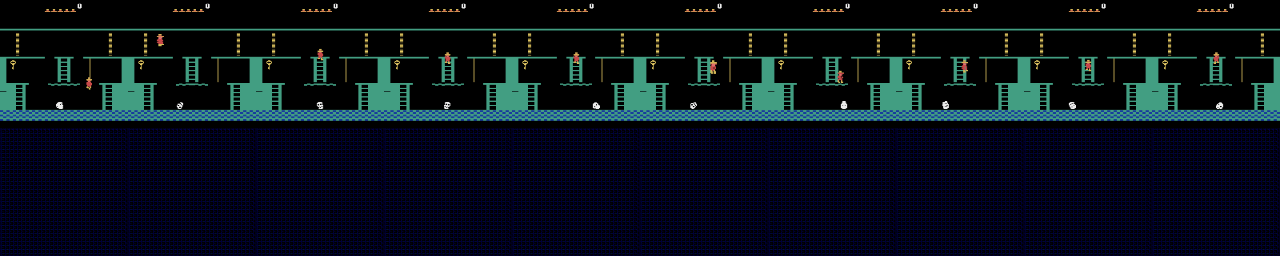

In [8]:
from PIL import Image
import torch

def build_recons_image(input: torch.Tensor, recons: torch.Tensor) -> Image:
    """
    Stack and return an image of inputs and reconstruction.
    :param input: Input images
    :param recons: Reconstructions
    :return: Image, first row is input images, second is reconstruction
    """
    # Clamp the values to [0, 1]
    recons = torch.clamp(recons, min=0.0, max=1.0)

    # Tensor to array, and transpose
    input = np.moveaxis(input.detach().cpu().numpy(), 1, 3)
    recons = np.moveaxis(recons.detach().cpu().numpy(), 1, 3)

    # Stack all images
    input = np.hstack(tuple(input))
    recons = np.hstack(tuple(recons))
    img = np.vstack((input, recons))

    img = Image.fromarray((img.squeeze() * 255).astype(np.uint8), "RGB")
    return img


build_recons_image(input, recons)


Create the loss function.

In [9]:
from torch import optim
import torch.nn.functional as F
buffer_size = 64
optimizer = optim.Adam(vae.parameters(), lr=2e-5)

for epoch in range(10000):
    input = buffer.sample(10).observations
    input = input.moveaxis(-1, -3)
    input = resize(input, (128, 128)).float() / 255
    input = input.to(device)
    out, latent_loss = vae(input)
    recon_loss = F.mse_loss(out, input)
    latent_loss = latent_loss.mean()
    loss = recon_loss + 0.25 * latent_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(
            f"epoch: {epoch: >5}\tloss: {loss.item():.5f}"
            f"\trecons error: {recon_loss.item():.5f}\tkl loss: {latent_loss.item():.5f}"
        )


epoch:     0	loss: 0.06298	recons error: 0.06270	kl loss: 0.00114
epoch:   500	loss: 0.25080	recons error: 0.02551	kl loss: 0.90118
epoch:  1000	loss: 0.36112	recons error: 0.02397	kl loss: 1.34861
epoch:  1500	loss: 0.01170	recons error: 0.00997	kl loss: 0.00690
epoch:  2000	loss: 0.00677	recons error: 0.00594	kl loss: 0.00333
epoch:  2500	loss: 0.00489	recons error: 0.00425	kl loss: 0.00253
epoch:  3000	loss: 0.00377	recons error: 0.00329	kl loss: 0.00193
epoch:  3500	loss: 0.00316	recons error: 0.00275	kl loss: 0.00166
epoch:  4000	loss: 0.00263	recons error: 0.00230	kl loss: 0.00131


KeyboardInterrupt: 

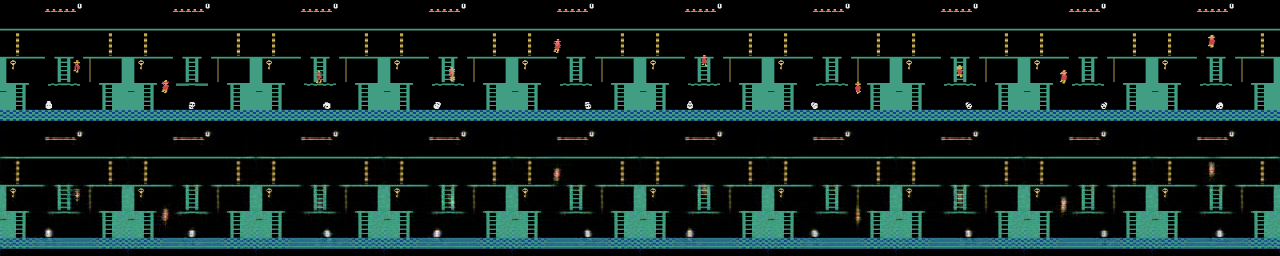

In [10]:
input = buffer.sample(10).observations
input = input.moveaxis(-1, -3)
input = resize(input, (128, 128)).float() / 255
input = input.to(device)
recons, mu = vae(input)
build_recons_image(input, recons)